### Imports

In [1]:
!pip install 'tf-nightly-gpu==1.14.1-dev20190409'
!pip install 'tensorflow_hub==0.4.0'

ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu==1.14.1-dev20190409 (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu==1.14.1-dev20190409
ERROR: Could not find a version that satisfies the requirement tensorflow_hub==0.4.0 (from versions: none)
ERROR: No matching distribution found for tensorflow_hub==0.4.0


In [4]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt

import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.enable_eager_execution()

# import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers 

## Part 1: Use TensorFlow Hub MobileNet for prediction

#### Download the classifier

In [7]:
classifier_url = ""

IMG_SHAPE = 224

model = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape = (IMG_SHAPE, IMG_SHAPE, 3))
])

NameError: name 'hub' is not defined

### Run it on single image

In [9]:
import PIL.image as Image
import numpy as np

grace_hopper = tf.keras.utils.get_file('image.jpg', )
grace_hopper = Image.open(grace_hopper).resize((IMG_SHAPE, IMG_SHAPE))

ModuleNotFoundError: No module named 'PIL.image'

In [10]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

NameError: name 'np' is not defined

In [11]:
result = model.predict(grace_hopper[np.newaxis, ...])

NameError: name 'model' is not defined

In [12]:
predicted_class = np.argmax(result = 0, axis = -1)
predicted_class

NameError: name 'np' is not defined

### Decode the predictions

In [13]:
labels_path = tf.keras.utils.get_file()
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
pred_class_name = imagenet_labels[predicted_class]
_  = plt.title("Prediction " + pred_class_name.title())

ValueError: Please specify the "origin" argument (URL of the file to download).

## Part 2: Use a TensorFlow Hub models for the cats vs dogs dataset

### Load Dataset

In [24]:
splits = tfds.Split.ALL.subsplit(weighted = (80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info  = True, splits = splits, as_supervised = True)

(train_examples, val_examples) = splits

num_examples = info.splits('train').num_examples
num_classes = info.features('label').num_examples

AttributeError: 'Split' object has no attribute 'subsplit'

Images are not in the same size

In [25]:
for i, image in enumerate(train_examples.take(3)):
    print("Image: {} Shape: {}".format(i+1, image.shape))

NameError: name 'train_examples' is not defined

#### Reformat all images to imagenet shape

In [26]:
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE)) / 255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(train_example//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
val_batches = val_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

NameError: name 'train_examples' is not defined

### Run the classifier on batch of images

In [27]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

results = model.predict(image_batch)

predicted_class_names = imagenet_labels(np.argmax(results, axis = -1))
predicted_class_names

NameError: name 'train_batches' is not defined

NameError: name 'image_batch' is not defined

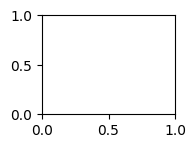

In [28]:
plt.figure(figsize = (10, 9))

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle('Imagenet predictions')

## Part 3: Do simple transfer learning with Tensorflow Hub

In [29]:
url = ""
features_extractor  = hub.KerasLayer(url,
                                    input_shape = (IMG_SHAPE, IMG_SHAPE, 3))

NameError: name 'hub' is not defined

In [30]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

NameError: name 'feature_extractor' is not defined

In [31]:
feature_extractor.trainable = False

NameError: name 'feature_extractor' is not defined

### Attach a classification head

In [32]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2, activation = 'softmax')
])

model.summary()

NameError: name 'feature_extractor' is not defined

### Train the model

In [34]:
model.compile(optimizer = 'adam', 
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                   epochs = EPOCHS,
                   validation_data = validation_batches)

NameError: name 'model' is not defined

#### Plot accuracy and loss

In [35]:
plt.figure(figsize = (12, 4))

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = "Train Accuracy");
plt.plot(epochs_range, val_accuracy, label = "Val Accuracy");
plt.title("Train and validation accuracy");
# plt.xticks(epochs_range);
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Train loss");
plt.plot(epochs_range, val_loss, label = "Val Loss");
plt.title("Train and validation loss");
# plt.xticks(epochs_range, rotation = 90);
plt.legend();

NameError: name 'EPOCHS' is not defined

<Figure size 1200x400 with 0 Axes>